## 加载 MNIST 数据集并合并训练集与测试集

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="data/", train=True, download=False, transform=transform
)

test_dataset = datasets.MNIST(
    root="data/", train=False, download=False, transform=transform
)

dataset = ConcatDataset([train_dataset, test_dataset])

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"总数据集大小: {len(dataset)}")

训练集大小: 60000
测试集大小: 10000
总数据集大小: 70000


## 可视化MNIST样本
每张图是 28 × 28 的灰度 MNIST 手写数字

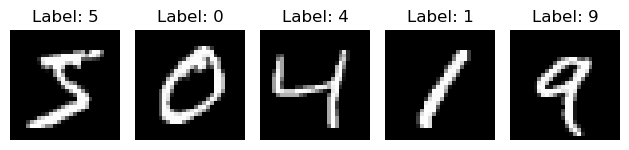

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5)

for i in range(5):
    image, label = dataset[i]
    axes[i].imshow(image.squeeze(0), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## 用于 MNIST 的条件 GAN（cGAN） 网络

条件信息采用 one-hot 标签形式，并通过全连接层与图像特征进行融合
使用 PyTorch 定义一个基于全连接层的 cGAN：
- 生成器（Generator）：将随机噪声和类别标签的 one-hot 编码映射为 MNIST 图像
- 判别器（Discriminator）：判断输入图像在给定条件下为“真实”的概率

In [3]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10, img_dim=28 * 28):
        super().__init__()
        self.num_classes = num_classes

        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        labels_onehot = torch.nn.functional.one_hot(labels, self.num_classes).float()
        x = torch.cat([z, labels_onehot], dim=1)
        img = self.model(x)

        return img


class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_dim=28 * 28):
        super().__init__()
        self.num_classes = num_classes

        self.model = nn.Sequential(
            nn.Linear(img_dim + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        labels_onehot = torch.nn.functional.one_hot(labels, self.num_classes).float()

        x = torch.cat([img, labels_onehot], dim=1)
        validity = self.model(x)

        return validity

## 构建 DataLoader 并初始化 GAN

In [4]:
from torch.utils.data import DataLoader

batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## 训练

Epoch [001/100] | G Loss: 7.4706 | D Loss: 0.0008
Epoch [002/100] | G Loss: 10.3586 | D Loss: 0.0026
Epoch [003/100] | G Loss: 4.7049 | D Loss: 0.1084
Epoch [004/100] | G Loss: 3.6937 | D Loss: 0.1047
Epoch [005/100] | G Loss: 3.9653 | D Loss: 0.8407
Epoch [006/100] | G Loss: 1.8368 | D Loss: 0.8370
Epoch [007/100] | G Loss: 3.4531 | D Loss: 0.1309
Epoch [008/100] | G Loss: 4.3041 | D Loss: 0.2523
Epoch [009/100] | G Loss: 4.3393 | D Loss: 0.4299
Epoch [010/100] | G Loss: 2.7607 | D Loss: 0.1314


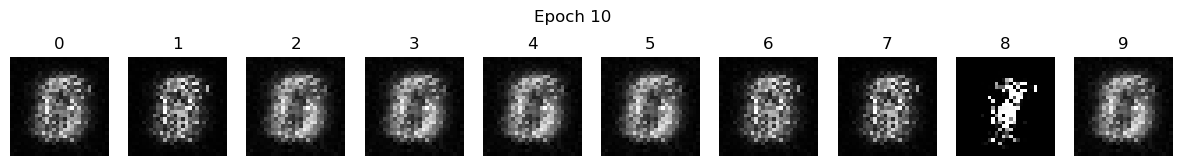

Epoch [011/100] | G Loss: 2.6467 | D Loss: 0.1895
Epoch [012/100] | G Loss: 3.3927 | D Loss: 0.0887
Epoch [013/100] | G Loss: 10.7416 | D Loss: 0.0285
Epoch [014/100] | G Loss: 4.3349 | D Loss: 0.0230
Epoch [015/100] | G Loss: 8.4451 | D Loss: 0.0290
Epoch [016/100] | G Loss: 12.1014 | D Loss: 0.2477
Epoch [017/100] | G Loss: 7.8806 | D Loss: 0.0058
Epoch [018/100] | G Loss: 7.9008 | D Loss: 0.0541
Epoch [019/100] | G Loss: 6.5587 | D Loss: 0.0130
Epoch [020/100] | G Loss: 8.5457 | D Loss: 0.0119


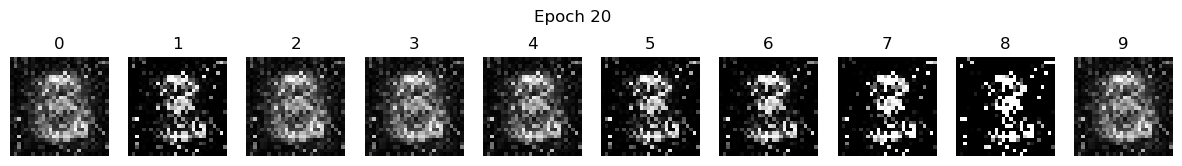

Epoch [021/100] | G Loss: 21.2063 | D Loss: 0.1305
Epoch [022/100] | G Loss: 9.7840 | D Loss: 0.0300
Epoch [023/100] | G Loss: 7.4091 | D Loss: 0.1074
Epoch [024/100] | G Loss: 11.0923 | D Loss: 0.0131
Epoch [025/100] | G Loss: 11.5894 | D Loss: 0.0269
Epoch [026/100] | G Loss: 7.6755 | D Loss: 0.0353
Epoch [027/100] | G Loss: 7.4014 | D Loss: 0.0413
Epoch [028/100] | G Loss: 5.6620 | D Loss: 0.1320
Epoch [029/100] | G Loss: 6.1253 | D Loss: 0.0380
Epoch [030/100] | G Loss: 5.2902 | D Loss: 0.1305


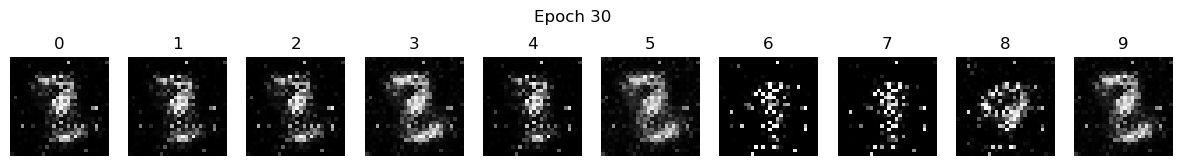

Epoch [031/100] | G Loss: 8.1233 | D Loss: 0.1704
Epoch [032/100] | G Loss: 6.1857 | D Loss: 0.1492
Epoch [033/100] | G Loss: 5.1846 | D Loss: 0.1021
Epoch [034/100] | G Loss: 4.0020 | D Loss: 0.1412
Epoch [035/100] | G Loss: 4.3233 | D Loss: 0.1062
Epoch [036/100] | G Loss: 3.8030 | D Loss: 0.1736
Epoch [037/100] | G Loss: 4.0887 | D Loss: 0.2252
Epoch [038/100] | G Loss: 3.6950 | D Loss: 0.2179
Epoch [039/100] | G Loss: 3.9948 | D Loss: 0.2204
Epoch [040/100] | G Loss: 3.2746 | D Loss: 0.1399


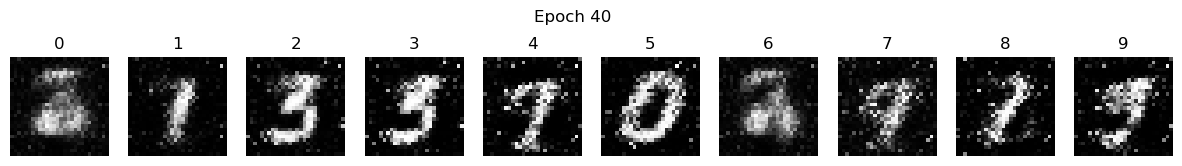

Epoch [041/100] | G Loss: 3.8630 | D Loss: 0.1004
Epoch [042/100] | G Loss: 4.1981 | D Loss: 0.1952
Epoch [043/100] | G Loss: 4.0779 | D Loss: 0.1886
Epoch [044/100] | G Loss: 4.3734 | D Loss: 0.1270
Epoch [045/100] | G Loss: 4.9603 | D Loss: 0.1507
Epoch [046/100] | G Loss: 4.2147 | D Loss: 0.1285
Epoch [047/100] | G Loss: 3.1079 | D Loss: 0.2857
Epoch [048/100] | G Loss: 3.0438 | D Loss: 0.2632
Epoch [049/100] | G Loss: 2.7359 | D Loss: 0.2420
Epoch [050/100] | G Loss: 2.6120 | D Loss: 0.2193


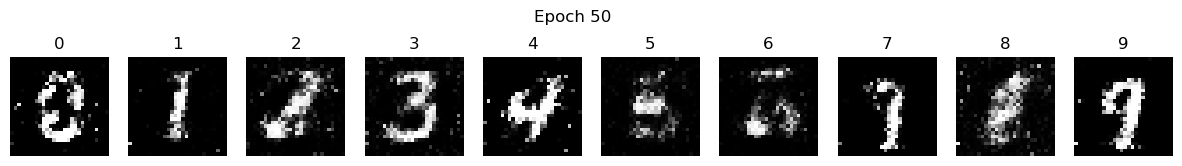

Epoch [051/100] | G Loss: 3.2228 | D Loss: 0.2685
Epoch [052/100] | G Loss: 3.2143 | D Loss: 0.2565
Epoch [053/100] | G Loss: 2.9377 | D Loss: 0.2324
Epoch [054/100] | G Loss: 3.0212 | D Loss: 0.2626
Epoch [055/100] | G Loss: 3.0913 | D Loss: 0.2335
Epoch [056/100] | G Loss: 3.4342 | D Loss: 0.2944
Epoch [057/100] | G Loss: 2.6230 | D Loss: 0.3831
Epoch [058/100] | G Loss: 3.2772 | D Loss: 0.3156
Epoch [059/100] | G Loss: 2.9095 | D Loss: 0.2669
Epoch [060/100] | G Loss: 2.0912 | D Loss: 0.2791


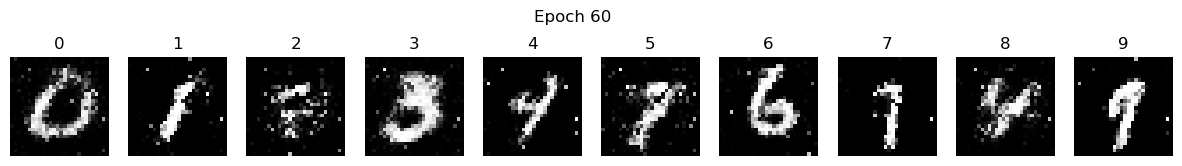

Epoch [061/100] | G Loss: 2.3796 | D Loss: 0.3226
Epoch [062/100] | G Loss: 2.7921 | D Loss: 0.3289
Epoch [063/100] | G Loss: 2.3160 | D Loss: 0.2912
Epoch [064/100] | G Loss: 2.3980 | D Loss: 0.3505
Epoch [065/100] | G Loss: 2.8981 | D Loss: 0.3360
Epoch [066/100] | G Loss: 2.6403 | D Loss: 0.3411
Epoch [067/100] | G Loss: 1.9033 | D Loss: 0.3868
Epoch [068/100] | G Loss: 2.4285 | D Loss: 0.3675
Epoch [069/100] | G Loss: 2.2516 | D Loss: 0.2962
Epoch [070/100] | G Loss: 2.7112 | D Loss: 0.3057


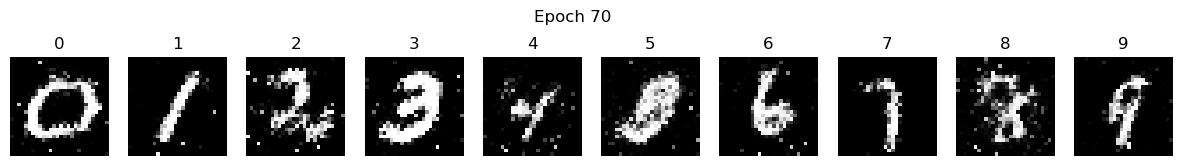

Epoch [071/100] | G Loss: 1.9922 | D Loss: 0.3882
Epoch [072/100] | G Loss: 2.2350 | D Loss: 0.4623
Epoch [073/100] | G Loss: 2.3958 | D Loss: 0.3217
Epoch [074/100] | G Loss: 2.3081 | D Loss: 0.4424
Epoch [075/100] | G Loss: 2.2834 | D Loss: 0.3082
Epoch [076/100] | G Loss: 2.4101 | D Loss: 0.3025
Epoch [077/100] | G Loss: 2.2935 | D Loss: 0.4034
Epoch [078/100] | G Loss: 2.1400 | D Loss: 0.3773
Epoch [079/100] | G Loss: 1.4242 | D Loss: 0.5094
Epoch [080/100] | G Loss: 2.2132 | D Loss: 0.3546


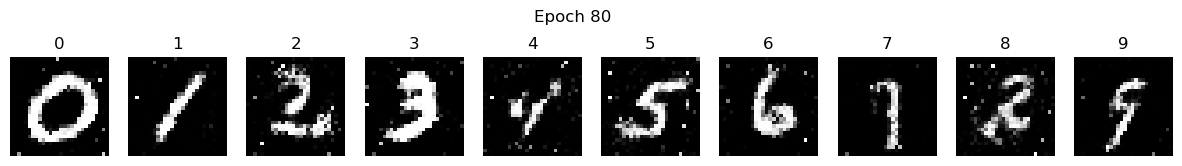

Epoch [081/100] | G Loss: 2.3231 | D Loss: 0.4034
Epoch [082/100] | G Loss: 1.8415 | D Loss: 0.4340
Epoch [083/100] | G Loss: 1.4530 | D Loss: 0.4497
Epoch [084/100] | G Loss: 1.8795 | D Loss: 0.4985
Epoch [085/100] | G Loss: 1.5293 | D Loss: 0.4959
Epoch [086/100] | G Loss: 1.4237 | D Loss: 0.5260
Epoch [087/100] | G Loss: 1.6802 | D Loss: 0.4029
Epoch [088/100] | G Loss: 1.6218 | D Loss: 0.4510
Epoch [089/100] | G Loss: 1.8961 | D Loss: 0.4501
Epoch [090/100] | G Loss: 1.5255 | D Loss: 0.5555


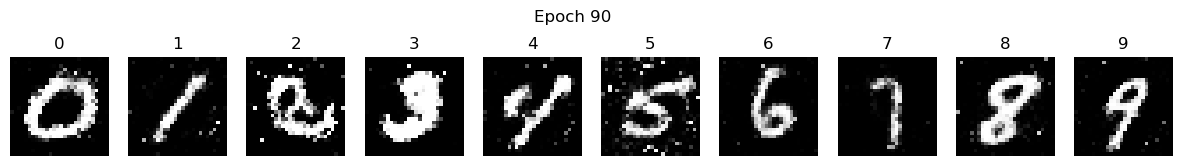

Epoch [091/100] | G Loss: 1.7252 | D Loss: 0.4218
Epoch [092/100] | G Loss: 1.5307 | D Loss: 0.5333
Epoch [093/100] | G Loss: 1.4377 | D Loss: 0.5012
Epoch [094/100] | G Loss: 1.5498 | D Loss: 0.4422
Epoch [095/100] | G Loss: 1.4731 | D Loss: 0.4466
Epoch [096/100] | G Loss: 1.3904 | D Loss: 0.4935
Epoch [097/100] | G Loss: 1.5331 | D Loss: 0.4937
Epoch [098/100] | G Loss: 1.4753 | D Loss: 0.4754
Epoch [099/100] | G Loss: 1.1435 | D Loss: 0.5955
Epoch [100/100] | G Loss: 1.6361 | D Loss: 0.4928


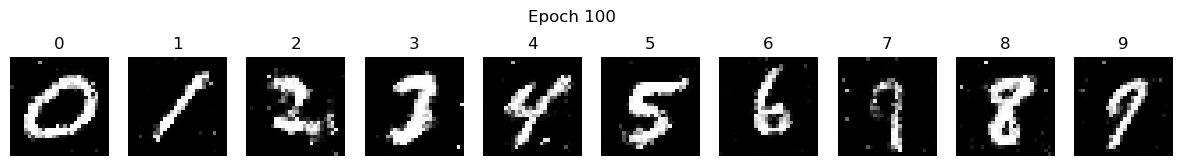

In [34]:
latent_dim = 100
fixed_z = torch.randn(10, latent_dim, device=device)
fixed_labels = torch.arange(0, 10, device=device)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

epochs = 100
G_losses = []
D_losses = []
for epoch in range(1, epochs + 1):
    for images, labels in dataloader:
        images = images.view(images.size(0), -1)  # [B, 1, 28, 28] → [B, 784]
        images = images * 2.0 - 1.0  # 归一化到 [-1, 1]
        images, labels = images.to(device), labels.to(device)

        valid = torch.ones(images.size(0), 1, device=device)
        fake = torch.zeros(images.size(0), 1, device=device)

        # ---------------------
        #  Train D
        # ---------------------
        optimizer_D.zero_grad()

        real_pred = discriminator(images, labels)
        d_real_loss = criterion(real_pred, valid)

        z = torch.randn(images.size(0), latent_dim, device=device)
        gen_images = generator(z, labels)
        fake_pred = discriminator(gen_images.detach(), labels)
        d_fake_loss = criterion(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train G
        # ---------------------
        optimizer_G.zero_grad()

        gen_pred = discriminator(gen_images, labels)
        g_loss = criterion(gen_pred, valid)

        g_loss.backward()
        optimizer_G.step()

    print(
        f"Epoch [{epoch:03d}/{epochs}] | "
        f"G Loss: {g_loss:.4f} | "
        f"D Loss: {d_loss:.4f}"
    )
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    # -------- 每 10 个 epoch 可视化 --------
    if epoch % 10 == 0:
        generator.eval()
        with torch.no_grad():
            samples = generator(fixed_z, fixed_labels)
            samples = (samples + 1) / 2.0
            samples = samples.view(-1, 28, 28).cpu()

        fig, axes = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            axes[i].imshow(samples[i], cmap="gray")
            axes[i].set_title(str(i))
            axes[i].axis("off")

        plt.suptitle(f"Epoch {epoch}")
        plt.show()
        generator.train()

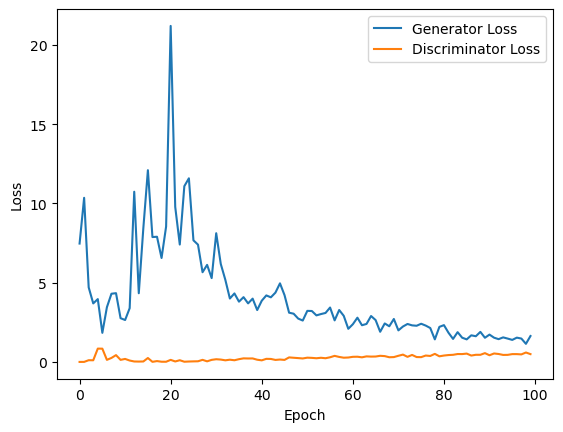

In [35]:
plt.figure()
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## WGAN（Wasserstein GAN）
判别器改称为“critic”（不再输出概率，而是一个实数评分

损失函数改为 Wasserstein 距离，不再用 BCE

Critic 训练目标：真实样本评分尽量大，生成样本评分尽量小

Generator 训练目标：生成样本评分尽量大

去掉 Sigmoid 激活

加入权重裁剪

In [5]:
import torch.nn.utils.spectral_norm as spectral_norm


class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].normal_(1, 0.02)
        self.embed.weight.data[:, num_features:].zero_()

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(
            -1, self.num_features, 1, 1
        )
        return out


class Generator(nn.Module):
    def __init__(self, latent_dim, num_class, nc=1, ngf=128, embed_dim=100):
        super().__init__()

        self.label_emb = nn.Embedding(num_class, embed_dim)

        input_dim = latent_dim + embed_dim
        self.tconv1 = nn.ConvTranspose2d(
            input_dim, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False
        )
        self.cbn1 = ConditionalBatchNorm2d(ngf * 8, num_class)
        self.prelu1 = nn.PReLU()
        # Input Dimension: (ngf*8) x 4 x 4
        self.tconv2 = nn.ConvTranspose2d(
            ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.cbn2 = ConditionalBatchNorm2d(ngf * 4, num_class)
        self.prelu2 = nn.PReLU()
        # Input Dimension: (ngf*4) x 8 x 8
        self.tconv3 = nn.ConvTranspose2d(
            ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False
        )
        self.cbn3 = ConditionalBatchNorm2d(ngf * 2, num_class)
        self.prelu3 = nn.PReLU()
        # Input Dimension: (ngf*2) x 16 x 16
        self.tconv4 = nn.ConvTranspose2d(
            ngf * 2, nc, kernel_size=4, stride=2, padding=3, bias=False
        )
        # Output Dimension: (nc) x 28 x 28

    def forward(self, x, labels):
        label_embed = self.label_emb(labels)  # [B, embed_dim]
        x = torch.cat([x, label_embed], dim=1)  # [B, latent_dim]
        x = x.unsqueeze(2).unsqueeze(3)  # [B, embed_dim, 1, 1]

        x = self.prelu1(self.cbn1(self.tconv1(x), labels))
        x = self.prelu2(self.cbn2(self.tconv2(x), labels))
        x = self.prelu3(self.cbn3(self.tconv3(x), labels))
        x = torch.tanh(self.tconv4(x))

        return x


class Discriminator(nn.Module):
    def __init__(self, num_class, nc=1, ndf=128):
        super().__init__()
        self.num_class = num_class
        self.ndf = ndf
        self.label_embed = nn.Embedding(self.num_class, ndf * 4)

        self.conv1 = spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1))  # 28*28->14*14
        self.conv2 = spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1))  # 14*14->7*7
        self.conv3 = spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1))  # 7*7->4*4
        self.final = spectral_norm(nn.Conv2d(ndf * 4, 1, 4, 1, 0))  # 4*4->1*1

        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()
        self.prelu3 = nn.PReLU()

    def forward(self, x, labels):
        h = self.prelu1(self.conv1(x))
        h = self.prelu2(self.conv2(h))
        h = self.prelu3(self.conv3(h))

        out = self.final(h).view(-1)  # [B]

        # projection term
        h_pool = torch.sum(h, dim=(2, 3))  # [B, ndf*4]
        emb = self.label_embed(labels)  # [B, ndf*4]
        proj = torch.sum(h_pool * emb, dim=1)  # [B]

        return out + proj

In [ ]:
latent_dim = 100
num_class = 10
fixed_z = torch.randn(10, latent_dim, device=device)
fixed_labels = torch.arange(0, 10, device=device)
generator = Generator(latent_dim, num_class).to(device)
discriminator = Discriminator(num_class).to(device)

optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=2e-4, betas=(0.0, 0.9), weight_decay=1e-3
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=2e-4, betas=(0.0, 0.9), weight_decay=1e-3
)

epochs = 100
G_losses = []
D_losses = []
for epoch in range(1, epochs + 1):
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # ---------------------
        #  Train D
        # ---------------------
        optimizer_D.zero_grad()

        d_real_loss = discriminator(images, labels)

        z = torch.randn(images.size(0), latent_dim, device=device)
        gen_images = generator(z, labels)
        d_fake_loss = discriminator(gen_images.detach(), labels)
        d_loss = torch.mean(d_fake_loss) - torch.mean(d_real_loss)
        d_loss.backward()
        optimizer_D.step()

        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        # ---------------------
        #  Train G
        # ---------------------
        optimizer_G.zero_grad()
        z = torch.randn(images.size(0), latent_dim, device=device)
        gen_images = generator(z, labels)
        g_loss = -torch.mean(discriminator(gen_images, labels))

        g_loss.backward()
        optimizer_G.step()

    print(
        f"Epoch [{epoch:03d}/{epochs}] | "
        f"G Loss: {g_loss:.4f} | "
        f"D Loss: {d_loss:.4f}"
    )
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    # -------- 每 10 个 epoch 可视化 --------
    if epoch % 1 == 0:
        generator.eval()
        with torch.no_grad():
            samples = generator(fixed_z, fixed_labels)
            # samples = (samples + 1) / 2.0
            samples = samples.view(-1, 28, 28).cpu()

        fig, axes = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            axes[i].imshow(samples[i], cmap="gray")
            axes[i].set_title(str(i))
            axes[i].axis("off")

        plt.suptitle(f"Epoch {epoch}")
        plt.show()
        generator.train()